<a href="https://colab.research.google.com/github/zaithevalex/regulator/blob/main/hw16_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="logo.png" height="900">
</center>


# Байесовская домашка

В этом задании мы оценим несколько простых моделей с помощью `pymc3`.

Задачи делались [на основе книги Байесовские методы для хакеров.](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) В ней вы можете найти ещё больше примеров использования байесовских методов с помощью pymc3.

In [9]:
# Чтобы избежать конфликта версий (библиотека pymc3 поддерживается до python 3.9 включительно):

# python -m venv myenv
# .\myenv\Scripts\activate
# py -3 -m venv myenv
#     .\myenv\Scripts\activate
# pip install ipykernel
# python -m ipykernel install --user --name=myenv --display-name="Python 3.9 (myenv)"

# ATTENTION: Перешел на pymc, вместо pymc3.

In [ ]:
# import sys
# IN_COLAB = 'google.colab' in sys.modules

# if IN_COLAB:
#     # 1. Uninstall existing python version
#     !apt-get remove -y python3.11 # Или версия, установленная по умолчанию
#     !apt-get autoremove -y
#     !apt-get autoclean -y

#     # 2. Install python 3.9
#     !sudo apt-get update
#     !sudo apt-get install python3.9

#     # 3. Create a symbolic link to make 'python' point to python3.9
#     !sudo ln -s /usr/bin/python3.9 /usr/bin/python

#     # 4. Install pip for python 3.9
#     !sudo apt install python3-pip
#     !sudo apt-get install python3.9-venv

#     # 5. Install ipykernel
#     !python -m pip install ipykernel

#     # 6. Add the new kernel to jupyter
#     !python -m ipykernel install --user --name=python3.9

#     print("Python 3.9 installed. Please restart the runtime.")

# else:
#   print("Not running on Google Colab.")

E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launc

In [68]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
import pymc as pm
pm.__version__

'5.21.2+18.g3a718f29'

# Упражнение 1 (Маша и медведи)

Помните задачку с вынюхиванием из лекции? Давайте начнём с того, что попробуем решить её в `pymc3`.

__Модель медведя:__ $y_i \sim N(m, 2^2)$

__Априорное мнение, где спряталась Маша:__ $m \sim N(1, 4^2)$

In [71]:
y = np.array([0.5, -1]) # медведи

Задайте априорное распределение и нашу модель.

In [72]:
basic_model = pm.Model()

with basic_model:
    m = pm.Normal("m", mu=1, sigma=4)
    obs = pm.Normal("obs", mu=m, sigma=2, observed=y)
    map_estimate = pm.find_MAP()


Output()

Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [73]:
assert np.abs(float(map_estimate['m']) + 0.111111) < 1e-4

# несколько похожих скрытых тестов

Обучите модельс с помощью MCMC, 500 итераций для обучения будет достаточно.

In [74]:
with basic_model:
    trace = pm.sample(500, tune=100, chains=4, random_seed=42)


Output()

Посмотрите на визуализацию Марковских цепей. Правда ли, что цепь сошлась?

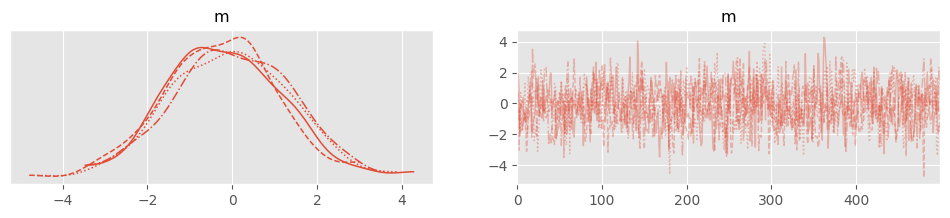

In [75]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
import arviz as az

with basic_model:
  az.plot_trace(trace)

Найдите вероятность $P(m < 0)$. Ответ запишите в переменную `ans_prob`.

In [76]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
ans_prob = np.mean(trace.posterior['m'] < 0)
print("P(m < 0):", ans_prob)

P(m < 0): <xarray.DataArray 'm' ()> Size: 8B
array(0.53)


In [77]:
assert ans_prob > 0.5

# несколько похожих скрытых тестов

Все цепи сошлись.

Распределение симметричное, а это соответствует нормальному априорному распределению.

# Упражнение 2 (Челленджер)

Байесовский подход - это просто другой способ оценивать те же самые модели. Например, давайте попробуем оценить логистическую регрессию.

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [78]:
df = pd.read_csv('data/challenger.csv', sep='\t')
print(df.shape)
df.head()

print(df)

(23, 3)
   Unnamed: 0  Temperature  Incident
0    Apr12.81         18.9         0
1    Nov12.81         21.1         1
2    Mar22.82         20.6         0
3    Nov11.82         20.0         0
4    Apr04.83         19.4         0
5    Jun18.83         22.2         0
6    Aug30.83         22.8         0
7    Nov28.83         21.1         0
8    Feb03.84         13.9         1
9    Apr06.84         17.2         1
10   Aug30.84         21.1         1
11   Oct05.84         25.6         0
12   Nov08.84         19.4         0
13   Jan24.85         11.7         1
14   Apr12.85         19.4         0
15   Apr29.85         23.9         0
16   Jun17.85         21.1         0
17   Jul29.85         27.2         0
18   Aug27.85         24.4         0
19   Oct03.85         26.1         0
20   Oct30.85         23.9         1
21   Nov26.85         24.4         0
22   Jan12.86         14.4         1


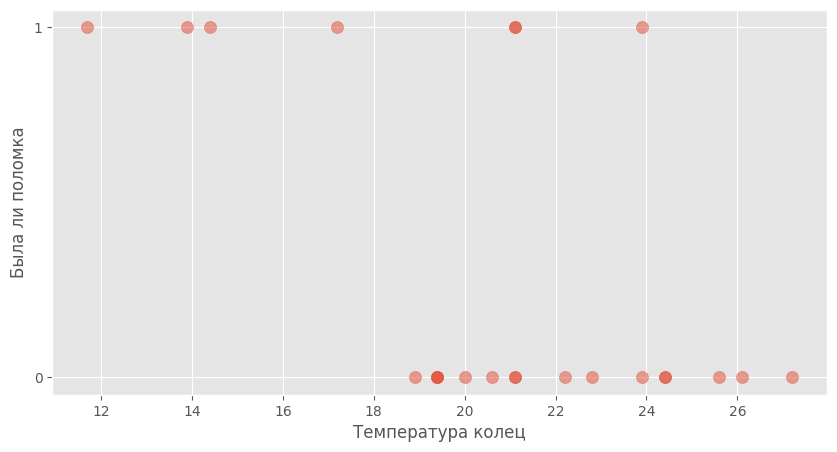

In [79]:
t = df.Temperature.values
y = df.Incident.values

plt.figure(figsize=(10, 5))
plt.scatter(t, y, s=75, alpha=0.5)
plt.yticks([0, 1])

plt.ylabel("Была ли поломка")
plt.xlabel("Температура колец");

In [80]:
! pip install theano


Обучим Байесовскую версию логистичесской регресcии.  Модель буде выглядеть следующим образом:

\begin{equation*}
\begin{aligned}
& \beta \sim N(0, 10^2) \\
& \alpha \sim N(0, 10^2) \\
& p \sim Bern(p) \\
& p = P(y = 1) = \frac{1}{1 + e^{\alpha + \beta \cdot t}}
\end{aligned}
\end{equation*}

In [81]:
import pytensor.tensor as tt


t = df.Temperature.values
y = df.Incident.values

with pm.Model() as model:

    beta = pm.Normal('beta', mu=0, sigma=10)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*t + alpha)))
    obs = pm.Bernoulli('y_obs', p=p, observed=y)


Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [82]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you


# your code here
with model:
    map_estimate = pm.find_MAP()

Output()

In [83]:
assert np.abs(float(map_estimate['beta']) - 0.1665) < 1e-2

# несколько похожих скрытых тестов

AssertionError: 

Попробуем обучить модель немного по-новому. В переменной `step` запишемм конкретный алгоритм, который будем использовать при обучении. В `pm.sapmple` укажем из какой точке надо стартовать алгоритму. В качестве стартовой точки укажем моду апостериорного распределения, полученную в предыдущем пункте.

In [84]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        random_seed=42,
        target_accept=0.9
    )

    burned_trace = trace.sel(draw=slice(500, None))
    burned_trace = burned_trace.sel(draw=slice(None, None, 10))

Output()

Посмотрим, сошлись ли цепи.

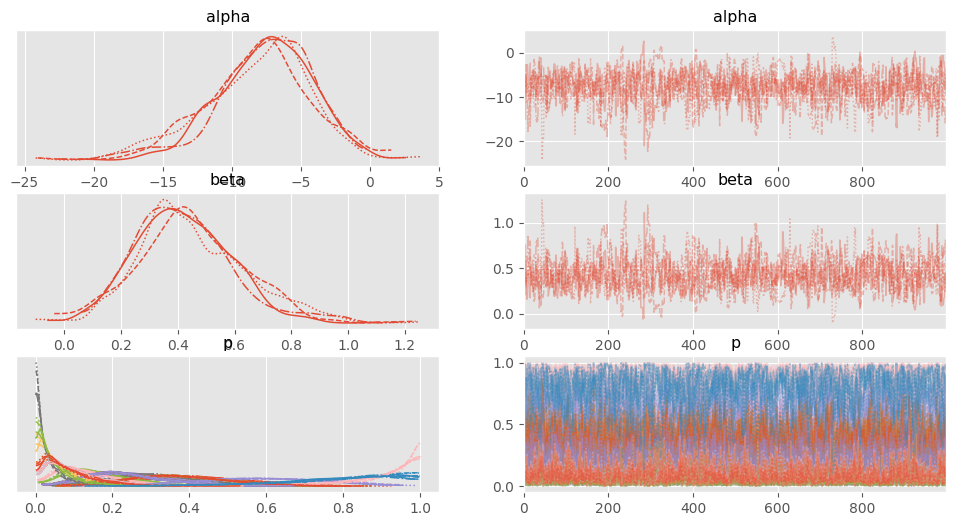

In [85]:
az.plot_trace(trace);

Какова вероятность того, что $\beta < 0.0001$? То есть, какова вероятность того, что между температурой и вероятностью поломки нет связи? Запишите овтет в переменную `prob_beta`.

In [86]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you


# your code here
prob_beta = (burned_trace.posterior['beta'].values < 0.0001).mean()

In [87]:
assert prob_beta < 0.1

# несколько похожих скрытых тестов

Нарисуем Получившиеся результаты. Для каждой температуры найдем $95\%$ байесовский интервал для вероятности того, что катастрофа произойдёт.

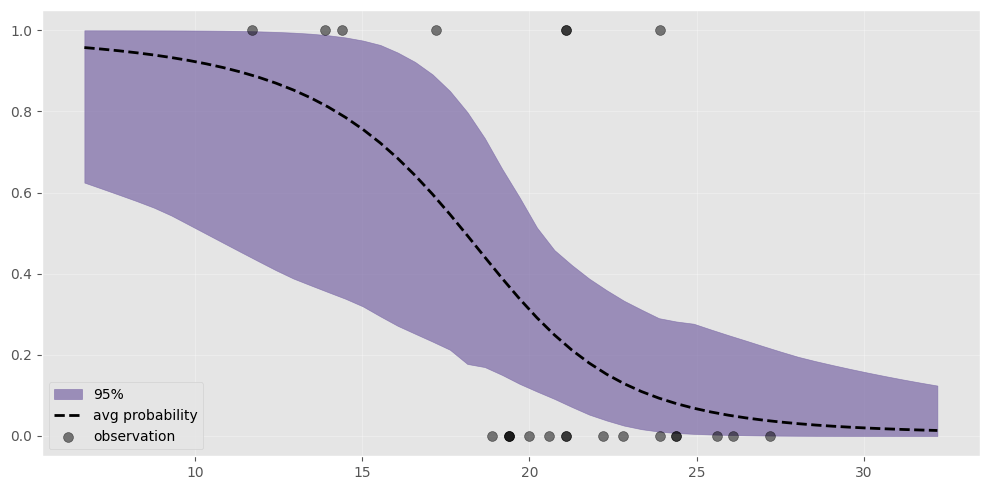

In [88]:
from scipy.stats.mstats import mquantiles

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t_seq = np.linspace(t.min() - 5, t.max() + 5, 50)[:, None]
beta_samples = burned_trace.posterior['beta'].values.reshape(-1, 1)
alpha_samples = burned_trace.posterior['alpha'].values.reshape(-1, 1)
p_seq = logistic(t_seq.T, beta_samples, alpha_samples)
mean_prob_t = p_seq.mean(axis=0)
qs = mquantiles(p_seq, [0.025, 0.975], axis=0)
plt.figure(figsize=(10, 5))
plt.fill_between(t_seq[:, 0], *qs, alpha=0.7, color="#7A68A6", label="95%")
plt.plot(t_seq[:, 0], mean_prob_t, lw=2, ls="--", color="k", label="avg probability")
plt.scatter(t, y, color="k", s=50, alpha=0.5, label="observation")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()

В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Найдите апостерионое распределение  вероятности катастрофы.

Text(0.5, 1.0, '31F')

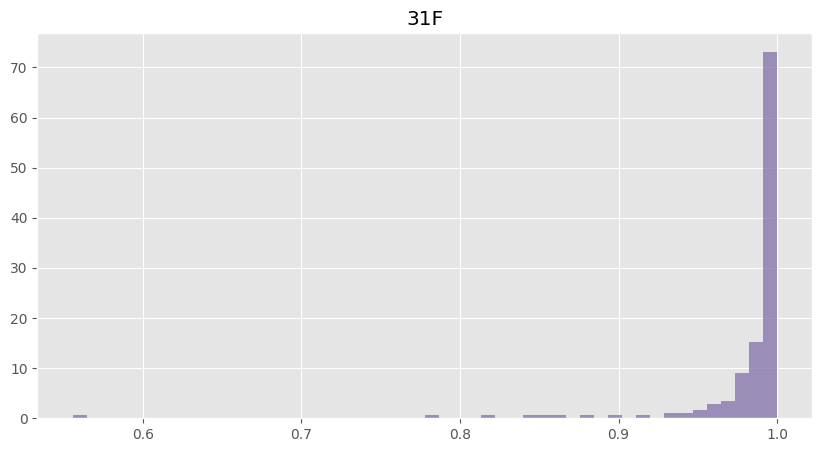

In [89]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
beta_samples = burned_trace.posterior['beta'].values.flatten()
alpha_samples = burned_trace.posterior['alpha'].values.flatten()
t_catastrophe = 31
p_catastrophe = 1 / (1 + np.exp(-(alpha_samples + beta_samples * t_catastrophe)))

plt.figure(figsize=(10, 5))
plt.hist(p_catastrophe, bins=50, density=True, alpha=0.7, color='#7A68A6')
plt.title('31F')

Найдите $5\%$ квантиль, математическое ожидание и $95\%$ квантиль апостериорного распределения. Заишите их в соответствующие переменные. Что это означает в контексте прогноза катастрофы?

In [90]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you


# your code here
q05 = np.quantile(p_catastrophe, 0.05)
avg = np.mean(p_catastrophe)
q95 = np.quantile(p_catastrophe, 0.95)

In [91]:
assert q05  > 0.8

# несколько похожих скрытых тестов